In [1]:
## Preliminary

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV

!pip install mitosheet 
import mitosheet 

!pip install xgboost
import xgboost

%config InlineBackend.figure_format = "svg"

In [3]:
df = pd.read_csv('../datasets/train.csv')

In [4]:
# Remove irrelevant columns

In [5]:
# Deleted columns property_id
df.drop(['property_id'], axis=1, inplace=True)

# Deleted columns property_name
df.drop(['property_name'], axis=1, inplace=True)

# Deleted columns property_summary
df.drop(['property_summary'], axis=1, inplace=True)

# Deleted columns property_space
df.drop(['property_space'], axis=1, inplace=True)

# Deleted columns property_desc
df.drop(['property_desc'], axis=1, inplace=True)

# Deleted columns property_neighborhood
df.drop(['property_neighborhood'], axis=1, inplace=True)

# Deleted columns property_notes
df.drop(['property_notes'], axis=1, inplace=True)

# Deleted columns property_transit
df.drop(['property_transit'], axis=1, inplace=True)

# Deleted columns property_access
df.drop(['property_access'], axis=1, inplace=True)

# Deleted columns property_interaction
df.drop(['property_interaction'], axis=1, inplace=True)

# Deleted columns property_rules
df.drop(['property_rules'], axis=1, inplace=True)

# Deleted columns property_sqfeet
df.drop(['property_sqfeet'], axis=1, inplace=True)

# Deleted columns property_scraped_at
df.drop(['property_scraped_at'], axis=1, inplace=True)

# Deleted columns property_last_updated
df.drop(['property_last_updated'], axis=1, inplace=True)

# Deleted columns host_id
df.drop(['host_id'], axis=1, inplace=True)

# Deleted columns host_location
df.drop(['host_location'], axis=1, inplace=True)

# Deleted columns host_about
df.drop(['host_about'], axis=1, inplace=True)

# Deleted columns host_nr_listings_total
df.drop(['host_nr_listings_total'], axis=1, inplace=True)

# Deleted columns host_verified
df.drop(['host_verified'], axis=1, inplace=True)

# Deleted columns booking_max_nights
df.drop(['booking_max_nights'], axis=1, inplace=True)

# Deleted columns reviews_first
df.drop(['reviews_first'], axis=1, inplace=True)

# Deleted columns reviews_last
df.drop(['reviews_last'], axis=1, inplace=True)

In [6]:
# Transform target to logarithm (target)
df['target'] = np.log(df['target'])

In [7]:
# Remove target outliers
Q1_target = df['target'].quantile(0.25)
Q3_target = df['target'].quantile(0.75)
IQR_target = Q3_target - Q1_target

lower_bound_target = Q1_target - 1.5 * IQR_target
upper_bound_target = Q3_target + 1.5 * IQR_target

df = df[(df['target'] >= lower_bound_target) & (df['target'] <= upper_bound_target)]

In [8]:
# Check for missing values
df['property_amenities'].isna().sum()

52

In [9]:
# Drop entires with missing values for property_amenities
df.dropna(subset=['property_amenities'], inplace=True)

In [10]:
df.property_amenities[:1].values

array(['Internet, Wireless Internet, Kitchen, Smoking allowed, Heating, Washer, Essentials, Shampoo, Hangers, Hair dryer, translation missing: en.hosting_amenity_49, translation missing: en.hosting_amenity_50'],
      dtype=object)

Text(0.5, 1.0, 'Frequency of Amenities in Airbnb Listings')

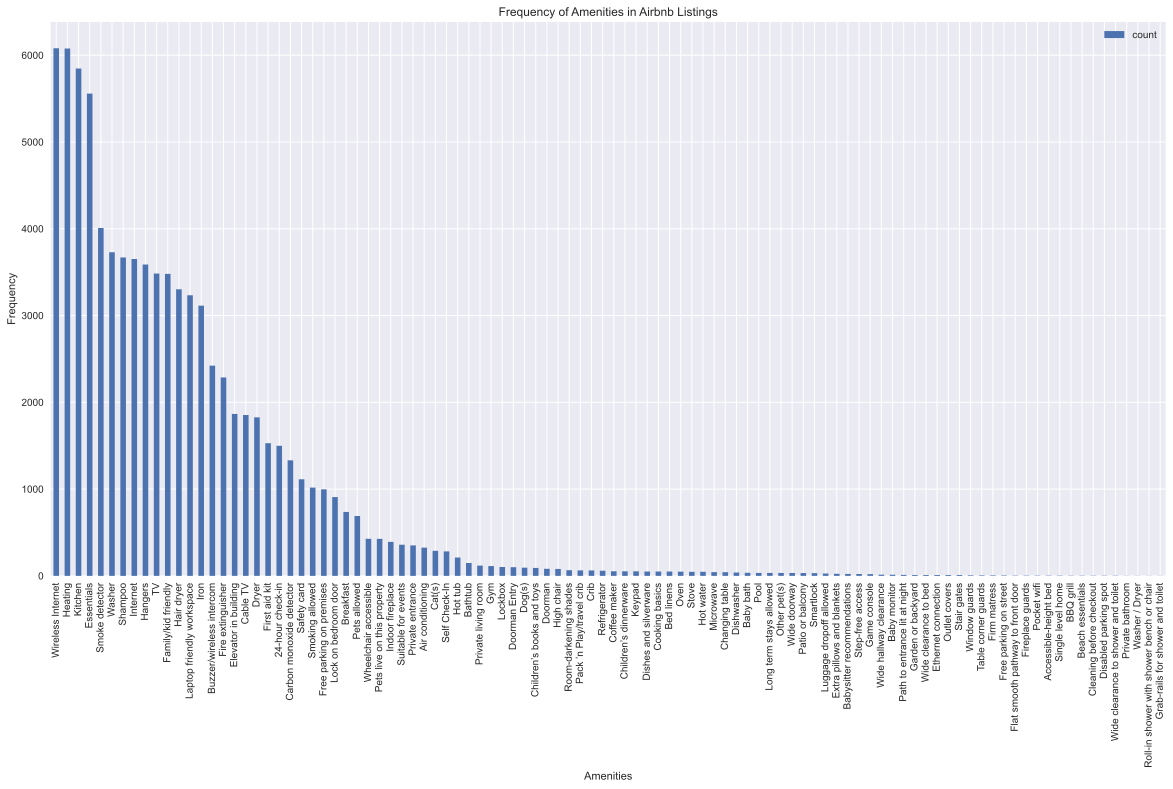

In [11]:
# extract the set of all amenities
amenities_list = df['property_amenities'].tolist()
amenities_set = set()
for amenity_string in amenities_list:
    if pd.notnull(amenity_string):
        amenities = amenity_string.split(',')
        for amenity in amenities:
            stripped_amenity = amenity.strip()
            if stripped_amenity and stripped_amenity not in ['translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50']:
                amenities_set.add(stripped_amenity)

# create a histogram of the frequency of amenities
amenities_counts = {}
for amenity in amenities_set:
    amenities_counts[amenity] = 0
for amenity_string in amenities_list:
    if pd.notnull(amenity_string):
        amenities = amenity_string.split(',')
        for amenity in amenities:
            stripped_amenity = amenity.strip()
            if stripped_amenity and stripped_amenity not in ['translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50']:
                amenities_counts[stripped_amenity] += 1
amenities_counts_df = pd.DataFrame.from_dict(amenities_counts, orient='index', columns=['count'])
amenities_counts_df = amenities_counts_df.sort_values(by='count', ascending=False)
amenities_counts_df.plot(kind='bar', figsize=(20,10))
plt.xlabel('Amenities')
plt.ylabel('Frequency')
plt.title('Frequency of Amenities in Airbnb Listings')

In [12]:
# make a dictionary from the amenities
amenities_counter = Counter()

# delete {},"",/,\, and split them by comma
df['property_amenities'].astype('str').str.strip('{}')\
                                       .str.replace('"', '')\
                                       .str.lstrip('\"')\
                                       .str.rstrip('\"')\
                                       .str.split(',')\
                                       .apply(amenities_counter.update)

# check how many amenities we have in total
print(len(amenities_counter))

# print the most common items
amenities_counter.most_common(25)

# create a new dictionary without amenities containing "translation missing"
amenities_counter_cleaned = {k: v for k, v in amenities_counter.items() if "translation missing" not in k}

120


In [13]:
amenities_counter.update(amenities_counter_cleaned)

In [14]:
for item,_ in amenities_counter.most_common(30):
    if 'translation missing' in item:
        continue
    col_name = 'amenity_' + item.replace(" ", "_")
    df[col_name] = df['property_amenities'].astype('str').apply(lambda x: int(item in x))

In [15]:
# Because of the reasons highlighted in this EDA, we have decided to NOT remove property_amenities
# as an attribute from our training set.